In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
BATCH_SIZE = 4096
DATA_TFREC = "data"
# create list of all tfrec files in folder and sub folders
TFREC_FILES = tf.io.gfile.glob(DATA_TFREC + '/**/*.tfrecord')
print(len(TFREC_FILES))
train_files = TFREC_FILES[1:46]
valid_files = TFREC_FILES[46:48]
train_options = tf.data.Options()
train_options.deterministic = True

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets'][60:120]

ds_train = (
  tf.data.TFRecordDataset(train_files, compression_type="GZIP")
    .with_options(train_options)
    .shuffle(100)
  .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files, compression_type="GZIP")
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

47


In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-22 07:59:11.344328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-22 08:00:55.696640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# mean_y = tf.cast(mean_y, tf.float64)
# stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
# min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
# max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

In [11]:
# min_y = tf.cast(min_y, tf.float64)
# max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [13]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [14]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    # x_flat2 = keras.ops.reshape(x[:, 556:], (-1, 1, 19))
    # x_flat2 = keras.ops.repeat(x_flat2, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def build_cnn(activation='relu'):    
    return keras.Sequential([
        # keras.layers.Conv1D(1024, 3, padding='same', activation=activation),
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
    ])

# Current track
X_input = x = keras.layers.Input(shape=(556,))
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x_seq = x_to_seq(x)

e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x_seq)
e = build_cnn()(e)
# Add global average to allow some communication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

p_all = keras.layers.Conv1D(1, 1, padding='same')(e)

# p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_all, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 60

# output = keras.ops.concatenate([p_seq[:,:60+12], -x[:, 60+12: 60+30]/1200, p_seq[:,60+30:]], axis=1)

# p_flat = p_all[:, :, 6:6 + 8+19]
# p_flat = keras.ops.mean(p_flat, axis=1)
# print(p_flat.shape)
# assert p_flat.shape[-1] == 27

# combined = keras.layers.concatenate([p_seq, p_flat], axis=1)

# shallow neural network combining cnn and input
# nn = keras.layers.Dense(60, activation='relu')(p_seq)
# nn = keras.layers.Dense(750, activation='relu')(nn)
# nn = keras.layers.Dense(500, activation='relu')(nn)
# output = keras.layers.Dense(350, activation='linear')(nn)

# output = keras.layers.Conv1D(1, 1, padding='same')(p_seq)

# Build & compile
model = keras.Model(inputs=X_input, outputs=p_seq)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)

model.build(input_shape=(None, 556))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      4,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    807,460 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 164)   │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 164)   │    807,460 │ add_1[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,619,349 (6.18 MB)

 Trainable params: 1,619,349 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/cnn2a.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/12
   9234/Unknown 4217s 456ms/step - loss: 0.3782 - r2_score: 0.3176

2024-06-22 09:11:13.194443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 09:11:13.194491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/IsInf/_114]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4251s 460ms/step - loss: 0.3782 - r2_score: 0.3176 - val_loss: 0.2901 - val_r2_score: 0.3756
Epoch 2/12


2024-06-22 09:11:47.107088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 09:11:47.107104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 0.3138 - r2_score: 0.4042

2024-06-22 10:20:38.292855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 10:20:38.292876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_54]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4166s 451ms/step - loss: 0.3138 - r2_score: 0.4042 - val_loss: 0.2823 - val_r2_score: 0.3951
Epoch 3/12


2024-06-22 10:21:13.512117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 10:21:13.512145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.3075 - r2_score: 0.4175

2024-06-22 11:34:12.042892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 11:34:12.042911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_84]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4415s 478ms/step - loss: 0.3075 - r2_score: 0.4175 - val_loss: 0.2805 - val_r2_score: 0.4018
Epoch 4/12


2024-06-22 11:34:48.683823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 11:34:48.683844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 0.3041 - r2_score: 0.4264

2024-06-22 12:46:03.096780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 12:46:03.096799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_84]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4311s 467ms/step - loss: 0.3041 - r2_score: 0.4264 - val_loss: 0.2776 - val_r2_score: 0.4048
Epoch 5/12


2024-06-22 12:46:39.857771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 12:46:39.857791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 0.3016 - r2_score: 0.4313

2024-06-22 13:57:24.390563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 13:57:24.390604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_6/_82]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4283s 464ms/step - loss: 0.3016 - r2_score: 0.4313 - val_loss: 0.2760 - val_r2_score: 0.4082
Epoch 6/12


2024-06-22 13:58:02.476348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 13:58:02.476364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_6]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.2995 - r2_score: 0.4355

2024-06-22 15:10:43.081087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_64]]
2024-06-22 15:10:43.081107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4393s 476ms/step - loss: 0.2995 - r2_score: 0.4355 - val_loss: 0.2752 - val_r2_score: 0.4114
Epoch 7/12


2024-06-22 15:11:15.250974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-22 15:11:15.250992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - loss: 0.2980 - r2_score: 0.4379

2024-06-22 16:17:25.028787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 16:17:25.028837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_26/_66]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4002s 433ms/step - loss: 0.2980 - r2_score: 0.4379 - val_loss: 0.2737 - val_r2_score: 0.4175
Epoch 8/12


2024-06-22 16:17:57.100119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 16:17:57.100138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 0.2965 - r2_score: 0.4422

2024-06-22 17:24:23.599393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 17:24:23.599420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_28/_68]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4019s 435ms/step - loss: 0.2965 - r2_score: 0.4422 - val_loss: 0.2733 - val_r2_score: 0.4190
Epoch 9/12


2024-06-22 17:24:56.422443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 17:24:56.422463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.2954 - r2_score: 0.4437

2024-06-22 18:31:35.024952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 18:31:35.024984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_86]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4032s 437ms/step - loss: 0.2954 - r2_score: 0.4437 - val_loss: 0.2725 - val_r2_score: 0.4216
Epoch 10/12


2024-06-22 18:32:08.375368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 18:32:08.375386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 0.2943 - r2_score: 0.4447

2024-06-22 19:40:04.940620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 19:40:04.940645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_88]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4112s 445ms/step - loss: 0.2943 - r2_score: 0.4447 - val_loss: 0.2715 - val_r2_score: 0.4235
Epoch 11/12


2024-06-22 19:40:40.198687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]
2024-06-22 19:40:40.198706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.2934 - r2_score: 0.4472

2024-06-22 20:52:33.583994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 20:52:33.584012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_26/_66]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4351s 471ms/step - loss: 0.2934 - r2_score: 0.4472 - val_loss: 0.2714 - val_r2_score: 0.4250
Epoch 12/12


2024-06-22 20:53:11.433080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 20:53:11.433098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_6]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 0.2926 - r2_score: 0.4492

2024-06-22 22:06:57.687437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 22:06:57.687456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_90]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 4463s 483ms/step - loss: 0.2926 - r2_score: 0.4492 - val_loss: 0.2707 - val_r2_score: 0.4278


2024-06-22 22:07:34.168338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-22 22:07:34.168356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


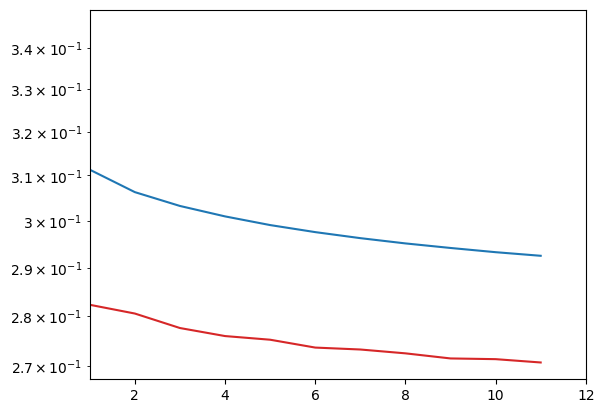

In [17]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [18]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-22 22:07:55.477753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


210/210 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step


2024-06-22 22:08:30.601396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
p_valid.numpy()[0]

array([ 9.89653346e-13,  6.80602439e-13,  4.22522287e-13,  6.15896114e-13,
        4.67553947e-13,  1.08819475e-12,  8.20267411e-13,  7.44223802e-13,
       -2.14494587e-13,  4.54135427e-13,  6.97530250e-13,  9.84095943e-13,
        6.46405997e-13,  3.80748140e-13,  5.38003940e-13,  1.85620616e-13,
       -2.00522270e-13, -5.26718643e-13, -2.94211270e-14, -3.59849477e-12,
        5.62063417e-13,  1.37018626e-11,  1.22525878e-11,  1.02645670e-12,
        3.52525786e-11,  2.40873432e-11, -8.17056423e-11, -5.64329694e-11,
        1.11854970e-10,  3.29689831e-10,  1.78218107e-09,  5.16166176e-09,
        5.42331868e-09,  3.90178823e-09,  4.41708270e-09,  5.25953237e-09,
        3.85177579e-09,  1.54442081e-09,  8.62272254e-10,  1.27022703e-09,
        2.06427409e-09,  7.27136795e-10, -1.19579346e-10, -6.85239476e-10,
        9.27990906e-10,  3.23912408e-09,  1.93257144e-09,  3.21421778e-11,
        2.30547403e-09,  1.61786406e-09, -9.32970257e-10, -1.91617189e-09,
       -2.33950637e-11,  

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:GPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();